In [1]:
pip install requests beautifulsoup4

In [2]:
pip install firebase

In [3]:
pip install matplotlib

In [4]:
from firebase import firebase
FBconn = firebase.FirebaseApplication('https://tut6-cloud-computing-default-rtdb.firebaseio.com/',None)


In [5]:
import requests
from bs4 import BeautifulSoup

def fetch_page(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    else:
        return None

In [6]:
import re

def index_words(soup):
    index = {}
    words = re.findall(r'\w+', soup.get_text())
    total_words = len(words)
    for word in words:
        word = word.lower()
        if word in index:
            index[word] += 1
        else:
            index[word] = 1
    return index, total_words

In [7]:
def remove_stop_words(index):
    stop_words = {'a', 'an', 'the', 'and', 'or', 'in', 'on', 'at'}
    for stop_word in stop_words:
        if stop_word in index:
            del index[stop_word]
    return index

In [8]:
from nltk.stem import PorterStemmer

def apply_stemming(index):
    stemmer = PorterStemmer()
    stemmed_index = {}
    for word, count in index.items():
        stemmed_word = stemmer.stem(word)
        if stemmed_word in stemmed_index:
            stemmed_index[stemmed_word] += count
        else:
            stemmed_index[stemmed_word] = count
    return stemmed_index

In [9]:
def search(query, index):

    stemmer = PorterStemmer()
    query_words = re.findall(r'\w+', query.lower())
    print(query)
    results = {}
    for word in query_words:
        word = stemmer.stem(word)
        if word in index:
            results[word] = index[word]
    return results

In [10]:
def search_engine(url, query):
    soup = fetch_page(url)
    if soup is None:
        return None, 0
    index, total_words = index_words(soup)
    index = remove_stop_words(index)
    index = apply_stemming(index)
    results = search(query, index)
    return results, total_words

In [11]:
def calculate_rank(results, total_words):
    rank = 0
    for word, count in results.items():
        relative_frequency = count / total_words # Calculate the relative frequency of each query word
        rank += relative_frequency # Sum the relative frequencies to get the rank
    return rank

In [12]:
url = 'https://cad.onshape.com/help/Content/Glossary/glossary.htm?tocpath=_____19'
query = 'point context keyboard see type studio draw back render also'
results, total_words = search_engine(url, query)
print(results)

rank = calculate_rank(results, total_words)
print('Rank:', rank)

result = FBconn.post('/words/', results)


point context keyboard see type studio draw back render also
{'point': 74, 'context': 676, 'keyboard': 631, 'see': 638, 'type': 656, 'studio': 369, 'draw': 226, 'back': 7, 'render': 159, 'also': 648}
Rank: 0.1688161375661376


In [13]:
firebase = firebase.FirebaseApplication('https://tut6-cloud-computing-default-rtdb.firebaseio.com/', None)
result = firebase.get('/words', None)
print(result)


{'-O1ljKjOq1-oSshksG6U': {'also': 648, 'back': 7, 'context': 676, 'draw': 226, 'keyboard': 631, 'point': 74, 'render': 159, 'see': 638, 'studio': 369, 'type': 656}, '-O1lnH9aYusXyZoUeU0k': {'also': 648, 'back': 7, 'context': 676, 'draw': 226, 'keyboard': 631, 'point': 74, 'render': 159, 'see': 638, 'studio': 369, 'type': 656}}


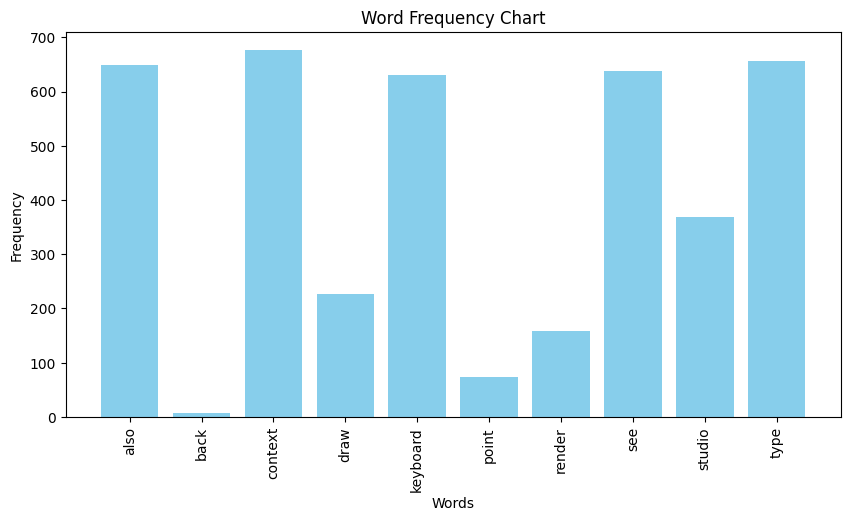

In [14]:
import matplotlib.pyplot as plt

# Flatten the result dictionary
flattened_result = {}
for key, value in result.items():
    for word, count in value.items():
        flattened_result[word] = count

# Prepare the data for plotting
keys = list(flattened_result.keys())
values = list(flattened_result.values())  # Extract values as a simple list

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(keys, values, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Chart')
plt.xticks(rotation=90)
plt.show()